In [16]:
#import libraries
from functools import partial

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa, analysis:ignore

import mne
from mne.stats import (ttest_1samp_no_p, bonferroni_correction, fdr_correction,
                       permutation_t_test, permutation_cluster_1samp_test)
print(__doc__)

Automatically created module for IPython interactive environment


In [17]:
width = 40
n_subjects = 10
signal_mean = 100
signal_sd = 100
noise_sd = 0.01
gaussian_sd = 5
sigma = 1e-3  # sigma for the "hat" method
n_permutations = 'all'  # run an exact test
n_src = width * width

# For each "subject", make a smoothed noisy signal with a centered peak
rng = np.random.RandomState(2)
X = noise_sd * rng.randn(n_subjects, width, width)
# Add a signal at the center
X[:, width // 2, width // 2] = signal_mean + rng.randn(n_subjects) * signal_sd
# Spatially smooth with a 2D Gaussian kernel
size = width // 2 - 1
gaussian = np.exp(-(np.arange(-size, size + 1) ** 2 / float(gaussian_sd ** 2)))
for si in range(X.shape[0]):
    for ri in range(X.shape[1]):
        X[si, ri, :] = np.convolve(X[si, ri, :], gaussian, 'same')
    for ci in range(X.shape[2]):
        X[si, :, ci] = np.convolve(X[si, :, ci], gaussian, 'same')

[[], [], Text(0.5, 1.0, 'Data averaged over subjects')]

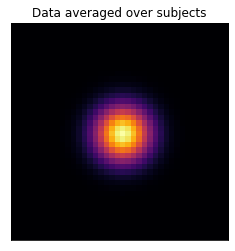

In [18]:
fig, ax = plt.subplots()
ax.imshow(X.mean(0), cmap='inferno')
ax.set(xticks=[], yticks=[], title="Data averaged over subjects")

In [19]:
sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = os.path.join(sample_data_folder, 'MEG', 'sample',
                                    'sample_audvis_filt-0-40_raw.fif')
raw = mne.io.read_raw_fif(sample_data_raw_file, preload=False)

sample_data_events_file = os.path.join(sample_data_folder, 'MEG', 'sample',
                                       'sample_audvis_filt-0-40_raw-eve.fif')
events = mne.read_events(sample_data_events_file)

raw.crop(tmax=90)  # in seconds; happens in-place
# discard events >90 seconds (not strictly necessary: avoids some warnings)
events = events[events[:, 0] <= raw.last_samp]

Opening raw data file C:\Users\sanji\mne_data\MNE-sample-data\MEG\sample\sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Current compensation grade : 0


In [20]:
channel_renaming_dict = {name: name.replace(' 0', '').lower()
                         for name in raw.ch_names}
_ = raw.rename_channels(channel_renaming_dict)  # happens in-place

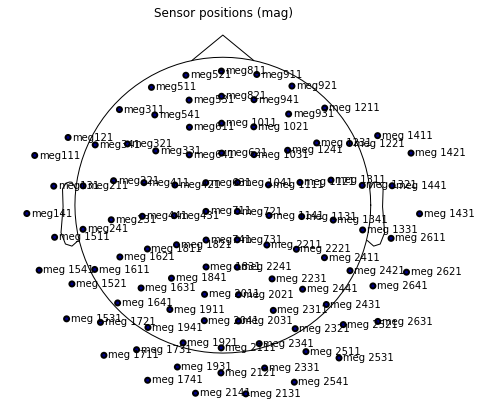

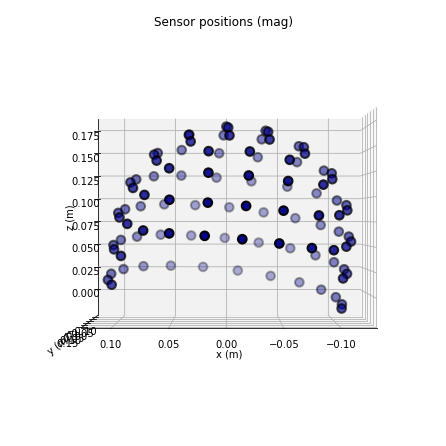

In [21]:
raw.plot_sensors(show_names=True)
fig = raw.plot_sensors('3d')

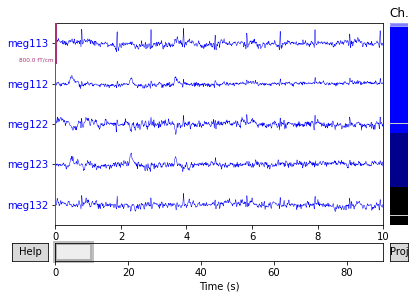

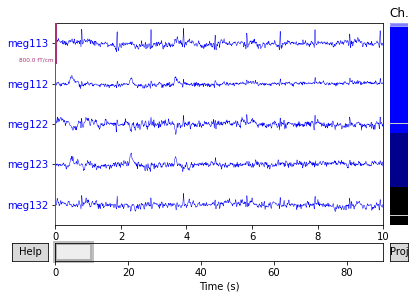

In [22]:
for proj in (False, True):
    fig = raw.plot(n_channels=5, proj=proj, scalings=dict(eeg=50e-6))
    fig.subplots_adjust(top=0.9)  # make room for title
    ref = 'Average' if proj else 'No'
    fig.suptitle(f'{ref} reference', size='xx-large', weight='bold')